In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zipped = !ls ./zippedData/
zipped = list(zipped)
path = "./zippedData/"
zipped_files = [path+x for x in zipped]
zipped_files

['./zippedData/bom.movie_gross.csv.gz',
 './zippedData/imdb.name.basics.csv.gz',
 './zippedData/imdb.title.akas.csv.gz',
 './zippedData/imdb.title.basics.csv.gz',
 './zippedData/imdb.title.crew.csv.gz',
 './zippedData/imdb.title.principals.csv.gz',
 './zippedData/imdb.title.ratings.csv.gz',
 './zippedData/rt.movie_info.tsv.gz',
 './zippedData/rt.reviews.tsv.gz',
 './zippedData/tmdb.movies.csv.gz',
 './zippedData/tn.movie_budgets.csv.gz']

In [3]:
def read_all(namelist):
    name_dict = {}
    for filename in namelist:
        name = filename[13:-7]
        if filename.endswith('csv.gz'):
            tmp_df = pd.read_csv(filename)
            name_dict[name] = tmp_df
        elif filename.endswith('tsv.gz'):
        #both tsv are encoded in ascii per cmd line and chardet, but for some reason 'latin' appears to do the trick:
            tmp_df = pd.read_csv(filename, sep='\t', encoding='latin')
            name_dict[name] = tmp_df
        #in case there are any additional files in the dir
        else:
            continue
    return name_dict
            

In [4]:
df_dict = read_all(zipped_files)
print(df_dict.keys())
type(df_dict['bom.movie_gross'])


dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tn.movie_budgets'])


pandas.core.frame.DataFrame

In [5]:
for df in df_dict.keys():
    print(df, df_dict[df].columns, len(df_dict[df]))

bom.movie_gross Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object') 3387
imdb.name.basics Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object') 606648
imdb.title.akas Index(['title_id', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'is_original_title'],
      dtype='object') 331703
imdb.title.basics Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object') 146144
imdb.title.crew Index(['tconst', 'directors', 'writers'], dtype='object') 146144
imdb.title.principals Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object') 1028186
imdb.title.ratings Index(['tconst', 'averagerating', 'numvotes'], dtype='object') 73856
rt.movie_info Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office'

In [6]:
#rt.reviews.tsv does not read: error encoding
# pd.read_csv(path+zipped_both[1], sep='\t').head(2)
# import chardet
# with open(path+zipped_both[1], 'rb') as raw:
#     result = chardet.detect(raw.read(7000))
    
# print(result)

#interesting points: 1) you don't need to unzip before reading, 2, pandas reads the .gz with encoding ascii, but does
#read the .tsv with same encoding, throws error, would like to know how to check the specific byte referenced as error?
# pd.read_csv(path+zipped[16], sep='\t', encoding='ascii',).tail(2)
# zipped[16]

In [7]:
bom_gross_df = df_dict['bom.movie_gross']
bom_gross_df['foreign_gross'] = pd.to_numeric(bom_gross_df.foreign_gross.str.replace(',', ''))
bom_gross_df.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross     float64
year                int64
dtype: object

In [8]:
bom_gross_df['total_gross'] = bom_gross_df['domestic_gross'] + bom_gross_df['foreign_gross']

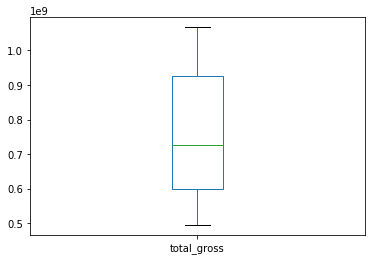

In [9]:
bom_gross_df.total_gross.head(10).plot(kind='box');

In [10]:
budgets_df = df_dict['tn.movie_budgets']

In [11]:

budgets_df['year'] = budgets_df.release_date.map(lambda x: int(x[-4:]))
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [12]:

budgets_df['worldwide_gross'] = budgets_df.worldwide_gross.str.replace('$', '').str.replace(',', '').astype('int')

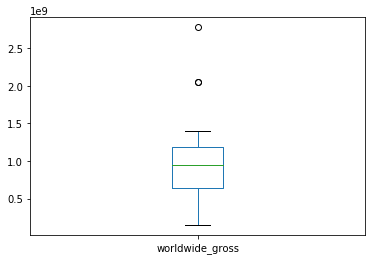

In [13]:
budgets_df.worldwide_gross.head(20).plot(kind='box')

In [14]:
budgets_df.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross       int64
year                  int64
dtype: object

In [15]:
budgets_df['production_budget'] = budgets_df.production_budget.str.replace('$', '').str.replace(',', '').astype('int')

In [16]:
budgets_df['profit'] = budgets_df.worldwide_gross - budgets_df.production_budget
budgets_df.sort_values(by='profit', ascending=False).head(20)
len(budgets_df)

5782

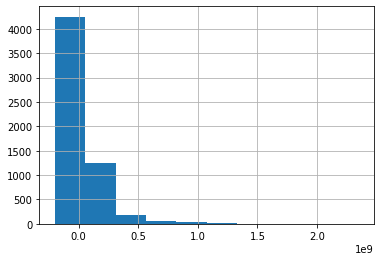

In [17]:
budgets_df.profit.hist()

In [18]:
movie_info_df = df_dict['rt.movie_info']

genre_add_on = movie_info_df.genre.str.split('|')
movie_info_exploded = movie_info_df.merge(genre_add_on, left_index=True, right_index=True).explode('genre_y')

movie_info_exploded.head()
#movie_info_df.columns
#new_genres
#movie_info_df

,id,synopsis,rating,genre_x,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_y
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Science Fiction and Fantasy


In [19]:
len(movie_info_df)

1560

In [20]:
df_dict.keys()

dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tn.movie_budgets'])

In [21]:
title_basics_df = df_dict['imdb.title.basics']
title_basics_df[title_basics_df['primary_title'] == 'Halloween']
title_basics_df['genre_list'] = title_basics_df['genres'].str.split(',')
title_basics_df.explode('genre_list')
title_basics_df[title_basics_df.primary_title == 'Avatar']

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre_list
17060,tt1775309,Avatar,Abatâ,2011,93.0,Horror,[Horror]


In [22]:
tmdb_movies_df = df_dict['tmdb.movies']
tmdb_movies_df[tmdb_movies_df.title == 'Halloween']

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
23894,23894,"[53, 27]",424139,en,Halloween,20.839,2018-10-19,Halloween,6.4,2020


In [23]:
#There are around 80 movies that have at least one duplicate name (likely different release dates) quick check of just
#the first one 'Halloween' in few other sets shows no duplicates, it may make sense to drop rows that do not appear
#in other sets
budget_duplicated_titles = budgets_df.movie.value_counts()[budgets_df.movie.value_counts() > 1]
budgets_df[budgets_df.movie.isin(budget_duplicated_titles.index)].release_date.value_counts()

budget_duplicated_titles.index.sort_values()

Index(['20,000 Leagues Under the Sea', 'A Nightmare on Elm Street', 'Aladdin',
       'Alice in Wonderland', 'Around the World in 80 Days',
       'Beauty and the Beast', 'Ben-Hur', 'Brothers', 'Ca$h', 'Carrie',
       'Casino Royale', 'Cat People', 'Cinderella', 'Clash of the Titans',
       'Conan the Barbarian', 'Crash', 'Crossroads', 'Dangerous Liaisons',
       'Dawn of the Dead', 'Day of the Dead', 'Death at a Funeral',
       'Fantastic Four', 'Flatliners', 'Footloose', 'Friday the 13th',
       'Ghostbusters', 'Godzilla', 'Halloween', 'Hamlet', 'Heist', 'Hellboy',
       'Hercules', 'Home', 'House of Wax', 'King Kong', 'Left Behind',
       'Legend', 'Life', 'Lolita', 'Night of the Living Dead', 'Notorious',
       'Pet Sematary', 'Peter Pan', 'Peteâs Dragon', 'Pinocchio',
       'Planet of the Apes', 'Point Break', 'Poltergeist', 'Robin Hood',
       'RoboCop', 'Serenity', 'Shaft', 'Side Effects', 'Snitch',
       'Teenage Mutant Ninja Turtles', 'The Alamo', 'The Avengers',


In [24]:
#confirming there are no duplicated release dates in the duplicated titles (there are not):
budgets_df[budgets_df.release_date == 'Aug 7, 2015']
budgets_df[budgets_df.release_date == 'Dec 31, 2012']
budgets_df[budgets_df.release_date == 'May 6, 2005']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit
338,39,"May 6, 2005",Kingdom of Heaven,110000000,"$47,398,413",218853353,2005,108853353
1686,87,"May 6, 2005",House of Wax,35000000,"$32,064,800",70064800,2005,35064800
3978,79,"May 6, 2005",Crash,7303082,"$55,334,418",101173038,2005,93869956
5555,56,"May 6, 2005",Fighting Tommy Riley,300000,"$10,514",10514,2005,-289486


In [25]:
merged_no_year = budgets_df.merge(title_basics_df, left_on='movie', right_on='primary_title')
merged_with_year = budgets_df.merge(title_basics_df, left_on=['movie', 'year'], right_on=['primary_title', 'start_year'])


print(len(merged_no_year), len(merged_with_year), len(budgets_df))

3815 1547 5782


count                                                          \
genre_list Action Adventure Animation Biography Comedy  Crime Documentary   
year                                                                        
2010         47.0      34.0       8.0       9.0   74.0   25.0         6.0   
2011         49.0      37.0      14.0      10.0   67.0   22.0         5.0   
2012         45.0      33.0      11.0       6.0   67.0   24.0         4.0   
2013         46.0      40.0      11.0      14.0   53.0   33.0         7.0   
2014         55.0      40.0      11.0      18.0   56.0   31.0        14.0   
2015         57.0      39.0       9.0      19.0   65.0   36.0         7.0   
2016         57.0      44.0      13.0      23.0   52.0   22.0         5.0   
2017         37.0      32.0      12.0      14.0   38.0   15.0         5.0   
2018         43.0      38.0       8.0      17.0   36.0   24.0         1.0   
2019         15.0      15.0       4.0       5.0   11.0    3.0         NaN   
2020          NaN       1.0       1.0       NaN    NaN    NaN         NaN   
All         451.0     353.0     102.0     135.0  519.0  235.0        54.0   

                                  ...          mean                           \
genre_list  Drama Family Fantasy  ...       Musical       Mystery Reality-TV   
year                              ...                                          
2010         84.0   21.0    17.0  ...  2.853252e+08  4.123649e+07        NaN   
2011         86.0   11.0    15.0  ...           NaN  9.847266e+07        NaN   
2012         74.0    8.0    13.0  ... -5.482816e+06  4.774557e+07        NaN   
2013         90.0   10.0    15.0  ...  4.252747e+07  7.543012e+07        NaN   
2014         96.0   11.0    11.0  ... -1.000000e+06  9.572394e+07        NaN   
2015        100.0   10.0    11.0  ...           NaN  2.835359e+07        NaN   
2016         80.0    9.0    12.0  ...           NaN  6.415274e+07 -1000000.0   
2017         64.0    3.0    14.0  ...  7.009326e+08  1.089014e+08        NaN   
2018         53.0    8.0    12.0  ...           NaN  3.633662e+07        NaN   
2019         16.0    3.0     4.0  ...           NaN  2.796568e+07        NaN   
2020          NaN    1.0     NaN  ...           NaN           NaN        NaN   
All         743.0   95.0   124.0  ...  2.542670e+08  6.355435e+07 -1000000.0   

                                                                    \
genre_list       Romance        Sci-Fi         Sport      Thriller   
year                                                                 
2010        4.572817e+07  1.431730e+08  6.406503e+07  6.134622e+07   
2011        4.841915e+07  1.471240e+08  1.901895e+07  5.684657e+07   
2012        4.538176e+07  2.807598e+08  1.793359e+06  1.138945e+08   
2013        2.505460e+07  2.493909e+08  2.420764e+07  5.792755e+07   
2014        3.916296e+07  2.750073e+08  2.645626e+07  6.583649e+07   
2015        4.755788e+07  2.319102e+08  2.887019e+07  8.915628e+07   
2016        3.793003e+07  3.255403e+08  1.187901e+07  3.984957e+07   
2017        4.438688e+07  1.862439e+08           NaN  1.528003e+08   
2018        8.914432e+07  3.809233e+08  9.605934e+07  1.144193e+08   
2019        4.237578e+07  1.960773e+08           NaN  5.722475e+07   
2020                 NaN           NaN           NaN           NaN   
All         4.531961e+07  2.491171e+08  2.743581e+07  7.978515e+07   

                                                      
genre_list           War       Western           All  
year                                                  
2010        6.313593e+07  9.189563e+07  8.514766e+07  
2011        1.430810e+07 -3.282693e+06  7.658402e+07  
2012       -1.973745e+06  1.761976e+08  1.070730e+08  
2013        2.363009e+07 -1.499788e+07  9.746501e+07  
2014        1.167323e+08 -3.674244e+06  1.020582e+08  
2015       -6.922274e+06 -6.000000e+07  8.999082e+07  
2016       -1.952338e+07  7.252516e+07  1.200102e+08  
2017       -1.520426e+07           NaN  1.571287e+08  

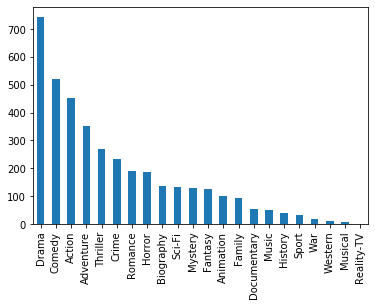

In [67]:
#merged_with_year.plot.scatter('year', 'profit', label='movie')
col_locs = list(range(1,8))
col_locs.append(10)
col_locs.append(-1)
merged_with_year.head()

merged_with_year.explode('genre_list').genre_list.value_counts().plot.bar()

merged_with_year.explode('genre_list').iloc[1:,col_locs].pivot_table(index='year', values='profit', columns='genre_list', aggfunc=['count','max','mean'], margins='true')
# merged_with_year.columns
